## Installing dependencies

In [ ]:
!pip install transformers accelerate evaluate datasets loralib git+https://github.com/huggingface/peft -q
!pip install sacrebleu
!pip install rouge

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.

## Importing libraries

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, PrefixTuningConfig, AdaLoraConfig, TaskType
import torch
import datasets
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset

import numpy as np
import pandas as pd
import gdown
from sklearn.model_selection import train_test_split
import pyarrow as pa
from sacrebleu.metrics import BLEU
from rouge import Rouge
import matplotlib.pyplot as plt

device = "cuda"
model_name_or_path = "t5-small" # "t5-large" "t5-base"
tokenizer_name_or_path = "t5-small" # "t5-large" "t5-base"

# checkpoint_name = "financial_sentiment_analysis_lora_v1.pt"
text_column = "table"
label_column = "summary"
max_length = 512
lr = 1e-3
num_epochs = 7
batch_size = 16

## Dataset creation (can be skipped)

In [ ]:
# for files saving
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_link = 'https://drive.google.com/file/d/1_pFWP_eiihkVboui67ed8ysQ3sJTsfdz/view?usp=sharing'
gdown.download(url=data_link, output="./dataset_nlg_v1.zip", quiet=True, fuzzy=True)
!unzip dataset_nlg_v1.zip

In [ ]:
def table_to_string(table_path):
  '''
  Inspired by https://arxiv.org/pdf/2005.11490.pdf, sec. 3.1

  Input: path to a .csv file

  Output: a string like 'Row number Column name 1: Value 1, Column name 2: Value 2,...'

  '''
  sample = pd.read_csv(table_path, index_col=0)
  cols = sample.columns
  for col in map(str, cols):
    sample[col] = col +': ' + sample[col].map(lambda x: str(x)) + ','
  sample.reset_index(inplace=True)
  sample['index'] = sample['index'].map(lambda x: str(x))
  return ' '.join(sample.to_numpy().flatten())

In [ ]:
SUMMARY_PREFIX = 'summarize: '
TARGET_FOR_SUMMARY = 'title' # 'text'

data = pd.read_csv('./dataset_nlg_v1/train.csv', index_col=0)

strings = []

for num in tqdm(map(str, data.index)):
  strings.append(table_to_string('./dataset_nlg_v1/data/' + num + '.csv'))

data['table'] = strings
# data = data + '</s>'


model_input = (SUMMARY_PREFIX + data['table']).to_numpy().flatten()
target = data[TARGET_FOR_SUMMARY].to_numpy().flatten()

all = pd.DataFrame({text_column: model_input, label_column: target})
train, eval = train_test_split(all,test_size = 0.2,random_state = 42)
train.reset_index(inplace=True, drop=True)
eval.reset_index(inplace=True, drop=True)
train.to_csv('/content/drive/MyDrive/t5_train.csv', index=False)
eval.to_csv('/content/drive/MyDrive/t5_eval.csv', index=False)

## Train preparation

In [ ]:
# quickstart with prepared files for training
data_link = "https://drive.google.com/file/d/1pkn1mFh_fbd35JkcqgfWSxmyNgYjlAMC/view?usp=sharing"
gdown.download(url=data_link, output="./t5_train.csv", quiet=True, fuzzy=True)

data_link = "https://drive.google.com/file/d/1DLNCjcqUm7sQ5NtRguh86DcaauZFF24O/view?usp=sharing"
gdown.download(url=data_link, output="./t5_eval.csv", quiet=True, fuzzy=True)

'./t5_eval.csv'

In [ ]:
train_data = pd.read_csv("./t5_train.csv")#.iloc[:20]
test_data = pd.read_csv("./t5_eval.csv")#.iloc[:20]

train_dataset = datasets.Dataset(pa.Table.from_pandas(train_data))
test_dataset = datasets.Dataset(pa.Table.from_pandas(test_data))

dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset['train'][0]

{'table': 'summarize: 0 Country: Russia, Medical device expenditure per capita: 42$, 1 Country: Brazil, Medical device expenditure per capita: 21$, 2 Country: China, Medical device expenditure per capita: 7$, 3 Country: India, Medical device expenditure per capita: 3$,',
 'summary': 'Medical device expenditure per capita in the largest emerging health markets in 2011'}

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=max_length // 4, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["test"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

Running tokenizer on dataset:   0%|          | 0/20256 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/5065 [00:00<?, ? examples/s]

In [ ]:
def train(model, optimizer, train_dataloader, eval_dataloader, num_epochs):
  model = model.to(device)

  train_losses = []
  eval_losses = []

  for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      for step, batch in enumerate(tqdm(train_dataloader)):
          batch = {k: v.to(device) for k, v in batch.items()}
          outputs = model(**batch)
          loss = outputs.loss
          total_loss += loss.detach().item()
          loss.backward()
          optimizer.step()
          lr_scheduler.step()
          optimizer.zero_grad()

      model.eval()
      eval_loss = 0
      eval_preds = []
      for step, batch in enumerate(tqdm(eval_dataloader)):
          batch = {k: v.to(device) for k, v in batch.items()}
          with torch.no_grad():
              outputs = model(**batch)
          loss = outputs.loss
          eval_loss += loss.detach().item()

          eval_preds.extend(
              tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
          )

      eval_epoch_loss = eval_loss / len(eval_dataloader)
      train_epoch_loss = total_loss / len(train_dataloader)
      eval_losses.append(eval_epoch_loss)
      train_losses.append(train_epoch_loss)
      print(f"{epoch=}: {train_epoch_loss=:.3f} {eval_epoch_loss=:.3f}")
  return train_losses, eval_losses, eval_preds

In [ ]:
def inference(eval_preds, eval_dataloader):
  # bleu
  bleu = BLEU()
  bleu_score = bleu.corpus_score(eval_preds, dataset["test"]["summary"]).score

  # rouge
  rouge = Rouge()
  rouge_score = rouge.get_scores(eval_preds, dataset["test"]["summary"], avg=True)
  rouge_score = {dct_k: {k: round(v, 2) for k, v in dct_v.items()} for dct_k, dct_v in rouge_score.items()}

  display(pd.DataFrame(rouge_score))
  print(f"{bleu_score=:.2f} on the evaluation dataset")
  print(f"{eval_preds[:10]=}")
  print(f"{dataset['test']['summary'][:10]=}")

## LoRA

In [ ]:
# creating model
peft_config = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

trainable params: 294912 || all params: 60801536 || trainable%: 0.4850403779272945


In [ ]:
# to check that the model does not solve the task without finetuning
model.eval()
model = model.to(device)
batch = next(iter(eval_dataloader))
batch = {k: v.to(device) for k, v in batch.items()}
outputs = model(**batch)
eval_out = tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
print(eval_out)
print(f"{dataset['test']['summary'][:10]=}")

['Rats- io of government expenditure to GDP domestic product a)::  to 2025*  5 5 5 5 5 5 5 5 Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat         5 5 5 5 5 5', "it: are climate change are.boundrift way  . but  to thenadachen'nf'.s'the.'. to the,0  you  a  problem change?. the    it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it              ", 'revenueenciesate revenue domestic in.C,,      revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue reve

In [ ]:
lora_train_loss, lora_eval_loss, lora_eval_preds = train(model, optimizer, train_dataloader, eval_dataloader, num_epochs)

100%|██████████| 317/317 [01:19<00:00,  3.99it/s]


epoch=0: train_epoch_loss=2.254 eval_epoch_loss=1.839


100%|██████████| 317/317 [01:19<00:00,  3.98it/s]


epoch=1: train_epoch_loss=1.944 eval_epoch_loss=1.741


100%|██████████| 317/317 [01:19<00:00,  3.98it/s]


epoch=2: train_epoch_loss=1.848 eval_epoch_loss=1.681


100%|██████████| 317/317 [01:19<00:00,  3.99it/s]


epoch=3: train_epoch_loss=1.791 eval_epoch_loss=1.648


100%|██████████| 317/317 [01:19<00:00,  3.97it/s]


epoch=4: train_epoch_loss=1.752 eval_epoch_loss=1.621


100%|██████████| 317/317 [01:19<00:00,  4.00it/s]


epoch=5: train_epoch_loss=1.721 eval_epoch_loss=1.606


100%|██████████| 317/317 [01:19<00:00,  3.99it/s]

epoch=6: train_epoch_loss=1.698 eval_epoch_loss=1.599


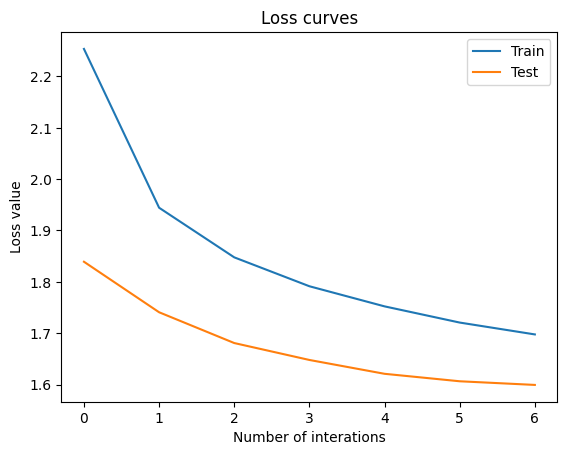

In [ ]:
plt.plot(lora_train_loss, label='Train')
plt.plot(lora_eval_loss, label='Test')
plt.legend()
plt.xlabel('Number of interations')
plt.ylabel('Loss value')
plt.title('Loss curves')
plt.show()

In [ ]:
inference(lora_eval_preds, eval_dataloader)

,rouge-1,rouge-2,rouge-l
r,0.63,0.44,0.62
p,0.64,0.35,0.63
f,0.63,0.39,0.62


bleu_score=0.03 on the evaluation dataset
eval_preds[:10]=['Bulgaria : Ratio of government expenditure to gross domestic product ( GDP ) from 2015 to 2025 Ghana Ghana Ghana Ghana Ghana Ghana Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Bulgaria Rat Rat Rat India India India India India India India

## AdaLoRA

In [ ]:
# data preprocessing for bart
bart_path = "facebook/bart-base"

ada_train_data = pd.read_csv("./t5_train.csv")#.iloc[:20]
ada_test_data = pd.read_csv("./t5_eval.csv")#.iloc[:20]
# remove "summarize: "
ada_train_data.table = ada_train_data.table.map(lambda x: x[10:])
ada_test_data.table = ada_test_data.table.map(lambda x: x[10:])

ada_train_dataset = datasets.Dataset(pa.Table.from_pandas(ada_train_data))
ada_test_dataset = datasets.Dataset(pa.Table.from_pandas(ada_test_data))

ada_dataset = datasets.DatasetDict({"train":ada_train_dataset,"test":ada_test_dataset})


ada_tokenizer = AutoTokenizer.from_pretrained(bart_path)

def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = ada_tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = ada_tokenizer(targets, max_length=max_length // 4, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


ada_processed_datasets = ada_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

ada_train_dataset = ada_processed_datasets["train"]
ada_eval_dataset = ada_processed_datasets["test"]

ada_train_dataloader = DataLoader(
    ada_train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
ada_eval_dataloader = DataLoader(ada_eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

Running tokenizer on dataset:   0%|          | 0/20256 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/5065 [00:00<?, ? examples/s]

In [ ]:
# creating model
peft_config = AdaLoraConfig(
    init_r=12,
    target_r=8,
    beta1=0.85,
    beta2=0.85,
    tinit=200,
    tfinal=1000,
    deltaT=10,
    lora_alpha=32,
    lora_dropout=0.1,
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
)

model = AutoModelForSeq2SeqLM.from_pretrained(bart_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

trainable params: 2434176 || all params: 141854688 || trainable%: 1.715964438200308


In [ ]:
# to check that the model does not solve the task without finetuning
model.eval()
model = model.to(device)
batch = next(iter(ada_eval_dataloader))
batch = {k: v.to(device) for k, v in batch.items()}
outputs = model(**batch)
eval_out = tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
print(eval_out)
print(f"{ada_dataset['test']['summary'][:10]=}")

['both annuala well Empires iPad ganzberen special have hisatings lastX annualenen well well well well well well wellsssssssssssssssssssssssssssssssssssssssssssXsssssssssssssssssssssssssssssss semi semi semis semi much much much much much much much,,,,,,,,,,,,', 'bothMagen port workingen writing,enX considered princesss portp- boilions princessn hugeX. portX princesss., princessri: double double working when princess princess GoenenenenenenenXXXXXXX,,,,,,,,,,,,,,,, in port port port in in that understand,, in,,, in in in in,,,,,,,en port port eye eye eye eye eye eye eye eye eye eye eye eye eye port port port port port port eye port portenen port portenen', 'both marketingensuring Two both. Here availableen to list both annualXXXXXXXXXXXXXXXX 60 60 60 60,, 60 60 60 be be 60 60 60 60 60XXXXX 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60X 60 60 60 60X 60 60 60 60XXX 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60XX,,,,,,,,,,,,, be be last list listXXXXX', 'both payment

In [ ]:
ada_lora_train_loss, ada_lora_eval_loss, ada_lora_eval_preds = train(model, optimizer, ada_train_dataloader, ada_eval_dataloader, num_epochs=6)

100%|██████████| 317/317 [02:37<00:00,  2.01it/s]


epoch=0: train_epoch_loss=4.751 eval_epoch_loss=4.199


100%|██████████| 317/317 [02:38<00:00,  2.01it/s]


epoch=1: train_epoch_loss=4.305 eval_epoch_loss=4.183


100%|██████████| 317/317 [02:37<00:00,  2.01it/s]


epoch=2: train_epoch_loss=4.252 eval_epoch_loss=4.164


100%|██████████| 317/317 [02:37<00:00,  2.01it/s]


epoch=3: train_epoch_loss=4.229 eval_epoch_loss=4.152


100%|██████████| 317/317 [02:37<00:00,  2.01it/s]


epoch=4: train_epoch_loss=4.213 eval_epoch_loss=4.145


100%|██████████| 317/317 [02:37<00:00,  2.01it/s]

epoch=5: train_epoch_loss=4.198 eval_epoch_loss=4.140


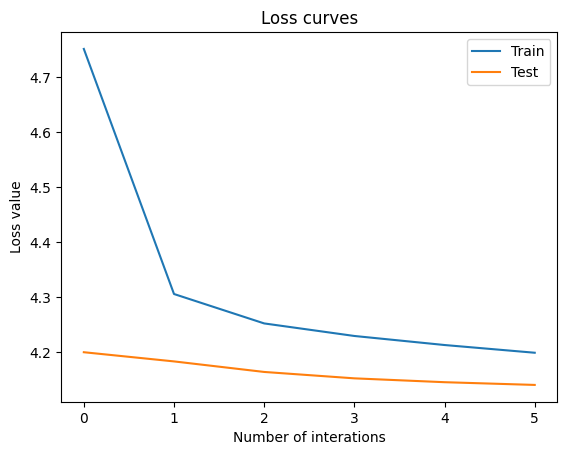

In [ ]:
plt.plot(ada_lora_train_loss, label='Train')
plt.plot(ada_lora_eval_loss, label='Test')
plt.legend()
plt.xlabel('Number of interations')
plt.ylabel('Loss value')
plt.title('Loss curves')
plt.show()

In [ ]:
inference(ada_lora_eval_preds, ada_eval_dataloader)

,rouge-1,rouge-2,rouge-l
r,0.01,0.0,0.01
p,0.02,0.0,0.02
f,0.01,0.0,0.01


bleu_score=0.26 on the evaluation dataset
eval_preds[:10]=["Un 2018 photography Grafa well Empires.00 ganzber be iPad relax' lists accomplished", 'connected appliesMage port working and writing and 1992 and like ands.tryhave nuitions somen and. aussi ands. deliverle was server: double double double UAE', "Eco Eco approach view ganza. managing available's ma", 'connected moved is. Get Chrome low and * *hot crusher and * and awardu award', 'litre peat She and. different andw sizesion and ma be and La"X–X East relax', "schön photography low' Joness award", 'compterX–X couldkindly electricala Ihrreinigt own payings help', "Safetya once heater Opena listed prototype''s ma", "addition bag dochster and. differentthe'-5s ma be and driver relax", "contactauf photographydeschidereaL'sees ma beatăsardu relax"]
dataset['test']['summary'][:10]=['France : Ratio of government expenditure to gross domestic product ( GDP ) from 2015 to 2025', "Discussions about climate change ad its consequences are ri

## Prefix Tuning

In [ ]:
# creating model
peft_config = PrefixTuningConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, num_virtual_tokens=20)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

trainable params: 122880 || all params: 60629504 || trainable%: 0.20267360260773368


In [ ]:
# to check that the model does not solve the task without finetuning
model.eval()
model = model.to(device)
batch = next(iter(eval_dataloader))
batch = {k: v.to(device) for k, v in batch.items()}
outputs = model(**batch)
eval_out = tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
print(eval_out)
print(f"{dataset['test']['summary'][:10]=}")

['Rats- io of government expenditure to GDP domestic product:a)::  to 201525*  5 5 5 5 5 5 5 5 5 Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat             ', "it: are climate change are.boundrift way  . but  to thenadachen'nf'.s'the.'. to the,.  you  a  problem change?. the   it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it", 'enciesate revenue domestic in.s,,      revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue revenue 

In [ ]:
PT_train_loss, PT_eval_loss, PT_eval_preds = train(model, optimizer, train_dataloader, eval_dataloader, num_epochs)

100%|██████████| 317/317 [01:15<00:00,  4.17it/s]


epoch=0: train_epoch_loss=4.051 eval_epoch_loss=2.961


100%|██████████| 317/317 [01:15<00:00,  4.17it/s]


epoch=1: train_epoch_loss=3.051 eval_epoch_loss=2.619


100%|██████████| 317/317 [01:15<00:00,  4.19it/s]


epoch=2: train_epoch_loss=2.841 eval_epoch_loss=2.508


100%|██████████| 317/317 [01:15<00:00,  4.18it/s]


epoch=3: train_epoch_loss=2.758 eval_epoch_loss=2.459


100%|██████████| 317/317 [01:15<00:00,  4.19it/s]


epoch=4: train_epoch_loss=2.711 eval_epoch_loss=2.433


100%|██████████| 317/317 [01:15<00:00,  4.18it/s]


epoch=5: train_epoch_loss=2.687 eval_epoch_loss=2.419


100%|██████████| 317/317 [01:15<00:00,  4.21it/s]

epoch=6: train_epoch_loss=2.677 eval_epoch_loss=2.415


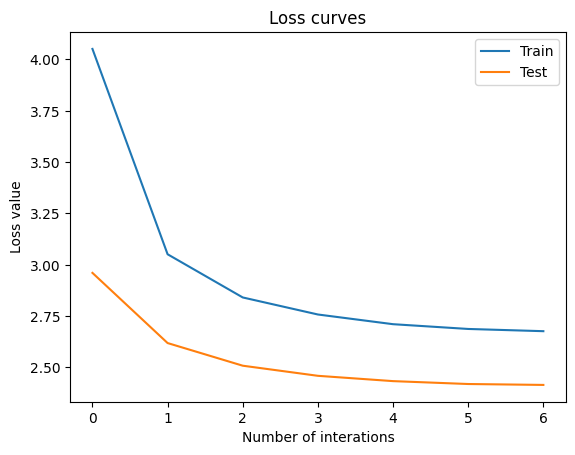

In [ ]:
plt.plot(PT_train_loss, label='Train')
plt.plot(PT_eval_loss, label='Test')
plt.legend()
plt.xlabel('Number of interations')
plt.ylabel('Loss value')
plt.title('Loss curves')
plt.show()

In [ ]:
inference(PT_eval_preds, eval_dataloader)

,rouge-1,rouge-2,rouge-l
r,0.50,0.28,0.48
p,0.54,0.22,0.52
f,0.52,0.24,0.50


bleu_score=0.04 on the evaluation dataset
eval_preds[:10]=['Rat : Ratio of government expenditure to GDP domestic product ( GDP ) from 2015 to 2025 ( Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat Rat', 'Global of of climate change in, year  impact on  in. by  to thenadachen nf,s   the., to the,, the you  a global threat change in?  it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it     The The The The The The No No It It It It It It It It               ', 'Revenueenciesate revenue domestic in the&C in to 2019 in Revenue Revenue Revenue Revenue Revenu